# **SETUP**


**Path to .json files**

In [1]:
ap = 'drive/My Drive/Python Projects/qm_project/anonymized_project.json'  # path to anonymized_project.json
ref = 'drive/My Drive/Python Projects/qm_project/references.json'         # path to references.json

**Importation**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

**Initial functions**

In [3]:
def get_result_keys(df):
    """
    Get dataframe and result_keys
    :param df: input dataframe
    :return: dataframe and result_keys
    """
    ap_results = df.iloc[0][0]['results']
    result_keys = list(ap_results.keys())
    return ap_results, result_keys


def get_img_keys(df):
    """
    Get dataframe and result_keys
    :param df: input dataframe
    :return: dataframe and result_keys
    """
    ref_keys = df.keys()
    return ref_df, ref_keys

**Load data**

In [4]:
ap_df = pd.read_json(ap)
ref_df = pd.read_json(ref)

ap_results, result_keys = get_result_keys(ap_df)
ref_df, ref_keys = get_img_keys(ref_df)

# **Task 1**
Gather insights about the annotators  


**a. How many annotators did contribute to the dataset?**  

**Conclusion:**  
There are 22 annotators that contribute to the dataset.

In [5]:
export_csv = True


annotators = []
for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])
    vendor_user_ids = [ap_results[result_key]['results'][i]['user']['vendor_user_id'] for i in range(result_amount)]

    # - Add data to list
    annotators.extend(vendor_user_ids)

# Get unique vendor_user_id
annotators = sorted(set(annotators))
annotators_df = pd.DataFrame({'vendor_user_id': annotators})

# Export data to csv file
if export_csv:
    annotators_df.to_csv("annotators.csv", index=False)

annotators_df

,vendor_user_id
0,annotator_01
1,annotator_02
2,annotator_03
3,annotator_04
4,annotator_05
5,annotator_06
6,annotator_07
7,annotator_08
8,annotator_09
9,annotator_10


**b. What are the average, min and max annotation times (durations)? Feel free to add visual representations here such as graphs if you like.**

**Conclusion:**  
There exists a few samples with the value of -99999 ms, which is considered to be error data.  
Moreover, samples labeled as corrupted are also excluded from assessment.  

Minimum annotation time: 10 ms  
Maximum annotation time: 42398 ms  
Average annotation time: 1289 ms

count    90861.000000
mean      1289.943661
std       1124.010057
min         10.000000
25%        887.000000
50%       1058.000000
75%       1328.000000
max      42398.000000
Name: duration, dtype: float64


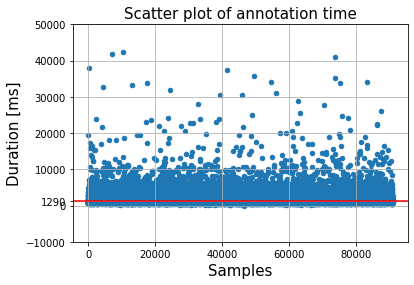

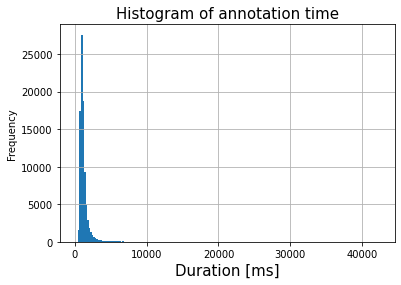

In [11]:
export_csv = True
remove_data_issue = True
fs = 15


def get_duration_data(result_key, index):
    """
    Get the corresponding duration data based on result_key and index
    :param result_key: key of anonymized_project result
    :param index: index of items in result key
    :return: a list of data
    """
    vendor_user_id = ap_results[result_key]['results'][index]['user']['vendor_user_id']
    duration = ap_results[result_key]['results'][index]['task_output']['duration_ms']
    image_url = ap_results[result_key]['results'][0]['task_input']['image_url']
    image_name = image_url.split("/")[-1]
    image_name = image_name.split(".")[0]
    return [vendor_user_id, image_name, duration, image_url]


durations = []
for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])

    # Collect durations which are not labeled as corrupted
    rows = [get_duration_data(result_key, i) for i in range(result_amount)
                if not ap_results[result_key]['results'][i]['task_output']['corrupt_data']]

    # - Add data to list
    durations.extend(rows)


# Store data in Pandas DataFrame
durations_df = pd.DataFrame(data=durations, columns=['vendor_user_id', 'image_name', 'duration', 'image_url'])
idxs = np.arange(0, len(durations))
durations_df['idx'] = idxs

# Remove data issue
if remove_data_issue:
    durations_df = durations_df.loc[durations_df['duration'] > 0]

# Export data to csv file
if export_csv:
    durations_df.to_csv("annotation_time.csv", index=False)

print(durations_df['duration'].describe())


# Scatter plot of annotation time
ax1 = durations_df.plot.scatter(x='idx', y='duration')
ax1.axhline(y=durations_df["duration"].mean(), color='r', linestyle='-')    # draw mean line
ax1.set_yticks(list(ax1.get_yticks()) + [durations_df["duration"].mean()])  # add extra tick for mean line
ax1.set_title("Scatter plot of annotation time", fontsize=fs)
ax1.set_xlabel("Samples", fontsize=fs)
ax1.set_ylabel("Duration [ms]", fontsize=fs)
ax1.grid(True)

# Histogram of annotation time
fig2, ax2 = plt.subplots()
ax2 = durations_df['duration'].plot.hist(bins=200)
ax2.set_title("Histogram of annotation time", fontsize=fs)
ax2.set_xlabel("Duration [ms]", fontsize=fs)
ax2.grid(True)

**Annotation time grouped by annotators**

In [12]:
export_csv = True

annotation_time_df = pd.read_csv("annotation_time.csv")
annotation_time_by_user_df = annotation_time_df.groupby("vendor_user_id")

# Stack data into list
annotation_time_by_user = []
for item in annotation_time_by_user_df:
    annotation_time_by_user.append([item[0], item[1]['duration'].mean(), item[1]['duration'].max(), item[1]['duration'].min()])

annotation_time_by_user_df = pd.DataFrame(data=annotation_time_by_user, columns=['vendor_user_id', 'mean', 'max', 'min'])

# Get types of annotation time
max_user_anno_time = annotation_time_by_user_df['max'].max()
min_user_anno_time = annotation_time_by_user_df['min'].min()
max_user_ave_anno_time = annotation_time_by_user_df['mean'].max()
min_user_ave_anno_time = annotation_time_by_user_df['mean'].min()

# Get users based on annotation time types
user_max_time = annotation_time_by_user_df.loc[annotation_time_by_user_df['max'] == max_user_anno_time]
user_min_time = annotation_time_by_user_df.loc[annotation_time_by_user_df['min'] == min_user_anno_time]
user_max_ave_time = annotation_time_by_user_df.loc[annotation_time_by_user_df['mean'] == max_user_ave_anno_time]
user_min_ave_time = annotation_time_by_user_df.loc[annotation_time_by_user_df['mean'] == min_user_ave_anno_time]

# Display
print("Max annotation time:         %.2f ms - by %s" % (max_user_anno_time, user_max_time['vendor_user_id'].values))
print("Min annotation time:         %.2f ms - by %s" % (min_user_anno_time, user_min_time['vendor_user_id'].values))
print("Max average annotation time: %.2f ms - by %s" % (max_user_ave_anno_time, user_max_ave_time['vendor_user_id'].values))
print("Min average annotation time: %.2f ms - by %s" % (min_user_ave_anno_time, user_min_ave_time['vendor_user_id'].values))

# Export data to csv file
if export_csv:
    annotation_time_by_user_df.to_csv("annotation_time_by_user.csv", index=False)

annotation_time_by_user_df

Max annotation time:         42398.00 ms - by ['annotator_06']
Min annotation time:         10.00 ms - by ['annotator_04']
Max average annotation time: 1687.78 ms - by ['annotator_19']
Min average annotation time: 879.43 ms - by ['annotator_22']


,vendor_user_id,mean,max,min
0,annotator_01,1077.323437,5120,526
1,annotator_02,1178.170090,24856,447
2,annotator_03,1460.249206,24190,503
3,annotator_04,1113.926958,19158,10
4,annotator_05,1562.089209,23037,263
5,annotator_06,1496.940217,42398,615
6,annotator_07,1578.362299,27727,525
7,annotator_08,1434.702111,33326,166
8,annotator_09,1198.814198,37428,534
9,annotator_10,1252.974603,37995,472


**Annotation time grouped by images**

Max annotation time:         42398.00 ms - of ['img_5245']
Min annotation time:         10.00 ms - of ['img_5100']
Max average annotation time: 5577.50 ms - of ['img_1340']
Min average annotation time: 738.90 ms - of ['img_8427']


,mean,max,min
count,9087.000000,9087.000000,9087.000000
mean,1289.927533,2932.915154,760.809838
std,395.941187,2843.046908,129.364879
min,738.900000,903.000000,10.000000
25%,1049.000000,1583.000000,677.000000
50%,1193.400000,2101.000000,748.000000
75%,1406.200000,3133.000000,832.000000
max,5577.500000,42398.000000,1421.000000


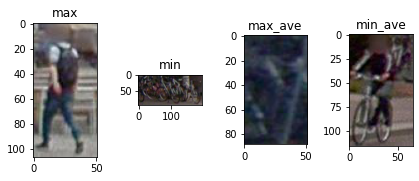

In [13]:
export_csv = True

annotation_time_df = pd.read_csv("annotation_time.csv")
annotation_time_by_image_df = annotation_time_df.groupby("image_name")

# Stack data into list
annotation_time_by_image = []
for item in annotation_time_by_image_df:
    annotation_time_by_image.append([item[0], item[1]['duration'].mean(), item[1]['duration'].max(), item[1]['duration'].min()])

annotation_time_by_image_df = pd.DataFrame(data=annotation_time_by_image, columns=['image_name', 'mean', 'max', 'min'])

# Get types of annotation time
max_image_anno_time = annotation_time_by_image_df['max'].max()
min_image_anno_time = annotation_time_by_image_df['min'].min()
max_image_ave_anno_time = annotation_time_by_image_df['mean'].max()
min_image_ave_anno_time = annotation_time_by_image_df['mean'].min()

# Get images based on annotation time types
image_max_time = annotation_time_by_image_df.loc[annotation_time_by_image_df['max'] == max_image_anno_time]
image_min_time = annotation_time_by_image_df.loc[annotation_time_by_image_df['min'] == min_image_anno_time]
image_max_ave_time = annotation_time_by_image_df.loc[annotation_time_by_image_df['mean'] == max_image_ave_anno_time]
image_min_ave_time = annotation_time_by_image_df.loc[annotation_time_by_image_df['mean'] == min_image_ave_anno_time]

# Display
print("Max annotation time:         %.2f ms - of %s" % (max_image_anno_time, image_max_time['image_name'].values))
print("Min annotation time:         %.2f ms - of %s" % (min_image_anno_time, image_min_time['image_name'].values))
print("Max average annotation time: %.2f ms - of %s" % (max_image_ave_anno_time, image_max_ave_time['image_name'].values))
print("Min average annotation time: %.2f ms - of %s" % (min_image_ave_anno_time, image_min_ave_time['image_name'].values))

# Export data to csv file
if export_csv:
    annotation_time_by_image_df.to_csv("annotation_time_by_image.csv", index=False)

# Visualization of the images
fig, ax = plt.subplots(1, 4)
fig.tight_layout()
images_df = [image_max_time, image_min_time, image_max_ave_time, image_min_ave_time]
titles = ['max', 'min', 'max_ave', 'min_ave']

for idx, item in enumerate(images_df):
    im_url = annotation_time_df.loc[annotation_time_df['image_name'] == item['image_name'].values[0]]
    im_url = im_url['image_url'].values[0]
    im = Image.open(requests.get(im_url, stream=True).raw)
    ax[idx].imshow(im)
    ax[idx].set_title(titles[idx])

annotation_time_by_image_df.describe()


**c. Did all annotators produce the same amount of results, or are there differences?**  

**Conclusion:**  
There are huge differences between the sample sizes of each annotator. Some annotators have up to approximately 6000 samples, while some others have only less than 500 samples.  
This will later be used as one of the attributes to evaluate the performance of the annotator.

,result_count
count,22.000000
mean,4130.454545
std,2403.233550
min,170.000000
25%,1852.500000
50%,4960.500000
75%,6189.000000
max,7596.000000


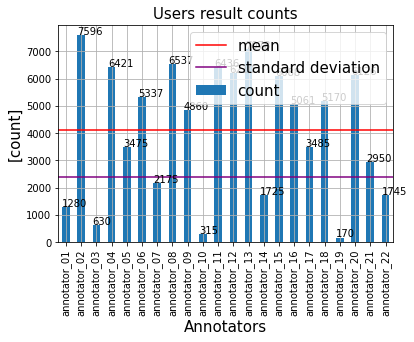

In [14]:
export_csv = True
fs = 15


annotators_list = []
for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])
    vendor_user_id = [ap_results[result_key]['results'][i]['user']['vendor_user_id'] for i in range(result_amount)]

    # - Add data to list
    annotators_list.extend(vendor_user_id)

# Count the occurrences of annotators
annotators, annotator_count = np.unique(np.array(annotators_list), return_counts=True)

# Store data in Pandas DataFrame
annotator_result_count_df = pd.DataFrame({"vendor_user_id": annotators, "result_count": annotator_count})

# Visualization
ax = annotator_result_count_df['result_count'].plot(kind='bar')
ax.set_xticklabels(annotator_result_count_df['vendor_user_id'])
ax.grid(True)
ax.set_title("Users result counts", fontsize=fs)
ax.set_xlabel("Annotators", fontsize=fs)
ax.set_ylabel("[count]", fontsize=fs)

ax.axhline(y=annotator_result_count_df["result_count"].mean(), color='r', linestyle='-')      # draw mean line
ax.axhline(y=annotator_result_count_df["result_count"].std(), color='purple', linestyle='-')  # draw std line
ax.legend(["mean", "standard deviation", "count"], prop={'size': fs})

# Add numbers to bars
for p, count in zip(ax.patches, annotator_result_count_df['result_count'].values):
    ax.annotate(str(count), (p.get_x(), p.get_height() + 20))

# Export data to csv file
if export_csv:
    annotator_result_count_df.to_csv("annotator_result_count.csv", index=False)

annotator_result_count_df.describe()

**d. Are there questions for which annotators highly disagree?**  

**Conclusion:**  
Questions with the **yes:no** ratio of **4:6**, **5:5** and **6:4** are considered as highly disagree questions. They take about **2.17%** of the entire dataset.

,yes:no,count,percent
0,0:10,3524,38.78
1,1:9,638,7.02
2,2:8,139,1.53
3,3:7,104,1.14
4,4:6,75,0.83
5,5:5,68,0.75
6,6:4,54,0.59
7,7:3,83,0.91
8,8:2,112,1.23
9,9:1,437,4.81


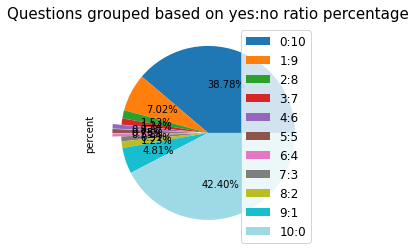

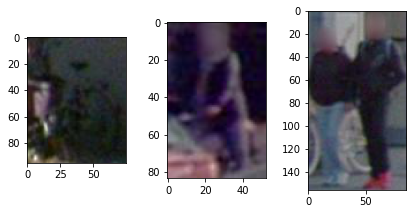

In [16]:
export_csv = True
fs = 15

question_answers = []

for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])
    answers = [ap_results[result_key]['results'][i]['task_output']['answer'] for i in range(result_amount)]
    solves = [ap_results[result_key]['results'][i]['task_output']['cant_solve'] for i in range(result_amount)]
    corrupts = [ap_results[result_key]['results'][i]['task_output']['corrupt_data'] for i in range(result_amount)]
    image_url = ap_results[result_key]['results'][0]['task_input']['image_url']
    image_name = image_url.split("/")[-1]
    image_name = image_name.split(".")[0]

    # Count the occurrence of each case 
    cant_solve = solves.count(True)
    corrupt_amount = corrupts.count(True)
    ans_yes = answers.count('yes')
    ans_no = answers.count('no')

    # - Add data to list
    question_answers.append([result_key, ans_yes, ans_no, cant_solve, corrupt_amount, image_name, image_url])


question_answers_df = pd.DataFrame(data=question_answers,
                                   columns=["result_key", "yes", "no", "cant_solve", "corrupt_data", "image_name", "image_url"])

# Specify the amount of 'yes' counts
yes_group = ['4', '5', '6']
highly_disagree_group_df = question_answers_df[question_answers_df['yes'].isin(yes_group)]


# Visualization
cs = plt.get_cmap('tab20')

# Group questions based on difference
question_answers_grouped = question_answers_df.groupby('yes')
total_answer = len(question_answers)

question_groups = [[int(item[0]), len(item[1])] for item in question_answers_grouped]
question_groups = [["{}:{}".format(item[0], 10 - item[0]), item[1], round(item[1] / total_answer * 100, 2)]
                   for item in sorted(question_groups)]
question_groups_df = pd.DataFrame(data=question_groups, columns=['yes:no', 'count', 'percent'])

question_groups_df = question_groups_df.astype({'count': int, 'percent': float})
explode = (0, 0, 0, 0, 0.1, 0.1, 0.1, 0, 0, 0, 0)
ax = question_groups_df.plot.pie(y='percent', autopct='%.2f%%', colormap=cs, labels=None, explode=explode)
ax.set_title("Questions grouped based on yes:no ratio percentage", fontsize=fs)
ax.legend(question_groups_df['yes:no'], prop={'size': 12})


# Export data to csv file
if export_csv:
    question_answers_df.to_csv("question_answers.csv", index=False)
    question_groups_df.to_csv("question_groups.csv", index=False)
    highly_disagree_group_df.to_csv("highly_disagree_group.csv", index=False)


# Display 3 random samples
highly_disagree_sample_df = highly_disagree_group_df.sample(n=3)
highly_disagree_sample_df = highly_disagree_sample_df['image_url']
urls = [item for item in highly_disagree_sample_df]
fig2, ax2 = plt.subplots(1, 3)
fig2.tight_layout()
for i in range(len(urls)):
    im = Image.open(requests.get(urls[i], stream=True).raw)
    ax2[i].imshow(im)

question_groups_df

# **Task 2**
Besides picking yes or no the annotators had the chance to tell if the data were corrupted or if they for any reason were not able to solve the task. These are fields 'cant_solve' and 'corrupt_data' given in the task_output.

**a. How often does each occur in the project and do you see a trend within the annotators that made use of these options?**  

**Conclusion:**  
The percentages of 'cant_solve' and 'corrupt_data' to happen are 0.5035% and 0.0727% respectively.
*   'annotator_04' and 'annotator_22', each marked 4 samples as 'cant_solve'.
*   'annotator_18' is the one made use of the option 'corrupt_data' most (2 samples).

There is no repetition of any sample among those marked with 'cant_solve' and 'corrupt_data'. Each sample in this region is unique.

Total percentage of 'cant_solve'  : 0.5035%
Total percentage of 'corrupt_data': 0.0727%


,vendor_user_id,cant_solve_percent,corrupt_data_percent
0,annotator_02,0.0263,0.0000
1,annotator_04,0.0623,0.0000
2,annotator_06,0.0000,0.0187
3,annotator_07,0.0460,0.0000
4,annotator_08,0.0306,0.0153
5,annotator_11,0.0155,0.0000
6,annotator_14,0.0580,0.0000
7,annotator_18,0.0193,0.0387
8,annotator_20,0.0163,0.0000
9,annotator_22,0.2292,0.0000


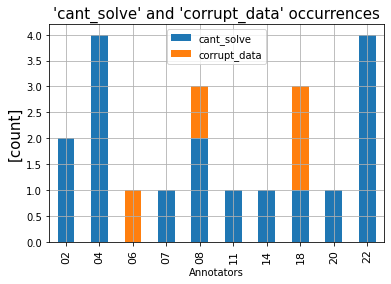

In [17]:
annotator_result_count_df = pd.read_csv("annotator_result_count.csv")
export_csv = True
fs = 15


def unsolved_check(result_key, index):
    """
    :param result_key: key of anonymized_project result
    :param index: index of items in result key
    :return: boolean value based on whether the answer is cant_solve or the data is corrupted
    """
    cant_solve_cond = ap_results[result_key]['results'][index]['task_output']['cant_solve']
    corrupt_data_cond = ap_results[result_key]['results'][index]['task_output']['corrupt_data']
    return cant_solve_cond or corrupt_data_cond


def get_data(result_key, index):
    """
    Get the corresponding data based on result_key and index
    :param result_key: key of anonymized_project result
    :param index: index of items in result key
    :return: a list of data
    """
    vendor_user_id = ap_results[result_key]['results'][index]['user']['vendor_user_id']
    cant_solve = ap_results[result_key]['results'][index]['task_output']['cant_solve']
    corrupt_data = ap_results[result_key]['results'][index]['task_output']['corrupt_data']
    return [vendor_user_id, int(cant_solve), int(corrupt_data)]


def get_user_result_count(user_id):
    """
    Get user's result count based on annotator id id
    :param user_id: annotator id
    :return: user's result count
    """
    annotator_result_count_dict = annotator_result_count_df.set_index('vendor_user_id').to_dict()
    count = annotator_result_count_dict['result_count'][user_id]
    return int(count)


# Gather rows of data with users with 'cant_solve' and 'corrupt_data'
unsolved_data = []

for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])
    unsolved = [get_data(result_key, i) for i in range(result_amount) if unsolved_check(result_key, i)]

    # - Add data to list
    unsolved_data.extend(unsolved)


# Get unique user ids
unsolved_user = sorted(set(np.array(unsolved_data)[:, 0]))


# Get the count of 'cant_solve' and 'corrupt_data' for each user and store them in a list
grouped_unsolved_data = []

for vendor_user_id in unsolved_user:
    # - Retrieve the answers of a specific user
    user_result = np.array([item for item in unsolved_data if item[0] == vendor_user_id])

    # - Count the 'cant_solve' and 'corrupt_data' occurrences
    cant_solve_count = np.sum(user_result[:, 1] == '1')
    corrupt_data_count = np.sum(user_result[:, 2] == '1')

    cant_solve_percent = round(cant_solve_count / get_user_result_count(vendor_user_id) * 100, 4)
    corrupt_data_percent = round(corrupt_data_count / get_user_result_count(vendor_user_id) * 100, 4)

    # - Add data to list
    grouped_unsolved_data.append([vendor_user_id, cant_solve_count, corrupt_data_count, cant_solve_percent, corrupt_data_percent])


# Store data in Pandas DataFrame
grouped_unsolved_data_df = pd.DataFrame(data=grouped_unsolved_data,
                                        columns=['vendor_user_id', 'cant_solve', 'corrupt_data', 'cant_solve_percent', 'corrupt_data_percent'])

# Export data to csv file
if export_csv:
    grouped_unsolved_data_df.to_csv("grouped_unsolved_data.csv", index=False)

# Visualization
display_df = grouped_unsolved_data_df[['cant_solve', 'corrupt_data']].astype(float)
xtick_label = [item.split("_")[1] for item in grouped_unsolved_data_df['vendor_user_id']]

ax = display_df.plot(kind='bar', stacked=True)
ax.set_xticklabels(xtick_label, fontsize=11)
ax.set_title("'cant_solve' and 'corrupt_data' occurrences", fontsize=fs)
ax.set_xlabel("Annotators")
ax.set_ylabel("[count]", fontsize=fs)
ax.grid(True)


print("Total percentage of 'cant_solve'  : {}%".format(grouped_unsolved_data_df['cant_solve_percent'].sum()))
print("Total percentage of 'corrupt_data': {}%".format(grouped_unsolved_data_df['corrupt_data_percent'].sum()))

grouped_unsolved_data_df[['vendor_user_id', 'cant_solve_percent', 'corrupt_data_percent']]

# **Task 3**
Is the reference set balanced? Please demonstrate via numbers and visualizations.  

**Conclusion:**  
The reference set is balanced with the percentage of True and False labels are 50.47% and 49.53%, respectively.

Text(0.5, 1.0, 'Reference set distribution percentage')

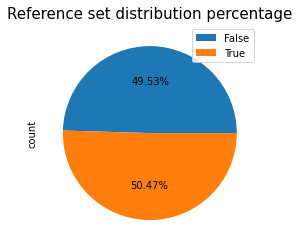

In [18]:
fs = 15


# Get data
ref_ans = [[ref_key, ref_df[ref_key]['is_bicycle']] for ref_key in ref_keys]
ref_ans = np.array(ref_ans)

# Store the collected data in Pandas DataFrame
ref_ans_df = pd.DataFrame({'key': ref_ans[:, 0], 'is_bicycle': ref_ans[:, 1]})
ref_ans_df = ref_ans_df.groupby('is_bicycle').nunique()
ref_ans_df = ref_ans_df.rename(columns={"key": "count"})
ax = ref_ans_df.plot.pie(y='count', autopct='%.2f%%', labels=None)
ax.set_title("Reference set distribution percentage", fontsize=fs)

# **Task 4**
Using the reference set, can you identify good and bad annotators? Please use statistics and visualizations. Feel free to get creative.

**Create data**

**Important note:**
This cell is used to collect data by doing cross-checking all answers with the reference set. The execution takes approximately 45 minutes to complete and it only needs to execute once to create the annotators_quality_assessment.csv file.

***There is no need to run this cell for evaluation if the annotators_quality_assessment.csv exits. Simply upload the file and ignore this cell.***

The 'null' column is used to indicates the amount of samples with 'cant_solve' or 'corrupt_data' labeled as True.

In [19]:
export_csv = True


def percent_cal(value, sum):
    """
    Calculate percent value
    """
    return value / sum * 100


# Get annotators
annotators = []
for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])
    vendor_user_ids = [ap_results[result_key]['results'][i]['user']['vendor_user_id'] for i in range(result_amount)]
    annotators.extend(vendor_user_ids)

annotators = sorted(set(annotators))


# Get reference set
ref_ans = [[key, ref_df[key]['is_bicycle']] for key in ref_keys]


# Get annotators' answers
annotators_ans = []
for result_key in result_keys:
    result_amount = len(ap_results[result_key]['results'])

    # annotators
    vendor_user_ids = [ap_results[result_key]['results'][i]['user']['vendor_user_id'] for i in range(result_amount)]

    # annotators' answers
    answers = [ap_results[result_key]['results'][i]['task_output']['answer'] for i in range(result_amount)]

    # image name
    image_url = ap_results[result_key]['results'][0]['task_input']['image_url']
    image_name = image_url.split("/")[-1]
    image_name = image_name.split(".")[0]

    for idx, ans in zip(vendor_user_ids, answers):
        annotators_ans.append([idx, image_name, ans])


# Group the annotators' answer by annotators
annotators_packages = []
for an_id in annotators:
    temp = [[idx, im_name, ans] for idx, im_name, ans in annotators_ans if an_id == idx]
    annotators_packages.append(temp)


# Count the correct, incorrect and null answers
annotators_quality = []
for annotator_package in annotators_packages:
    # - Initialization of counters
    correct, incorrect, null = 0, 0, 0

    # - Current annotator
    vendor_user_id = annotator_package[0][0]

    # - Looping through each package and count the correct, incorrect and null answer
    for user_id, im_name, user_an in annotator_package:
        # -- Get row index of reference answer
        idx = [i for i, ref in enumerate(ref_ans) if im_name in ref][0]

        # -- Conditions
        correct_cond1 = user_an == 'yes' and ref_ans[idx][1]
        correct_cond2 = user_an == 'no' and not ref_ans[idx][1]
        null_cond = user_an == ""

        # -- Check condition and count
        if correct_cond1 or correct_cond2:
            correct += 1
        elif null_cond:
            null += 1
        else:
            incorrect += 1

    total = correct + incorrect + null

    # - Add data to list
    annotators_quality.append([vendor_user_id, correct, incorrect, null, total,
                               percent_cal(correct, total), percent_cal(incorrect, total), percent_cal(null, total)])

    print(vendor_user_id, correct, incorrect, null, total,
                               percent_cal(correct, total), percent_cal(incorrect, total), percent_cal(null, total))


# Store data in Pandas DataFrame
annotators_quality_df = pd.DataFrame(data=annotators_quality,
                                     columns=['vendor_user_id', 'correct', 'incorrect', 'null', 'total',
                                              'correct_p', 'incorrect_p', 'null_p'])

# Export data to csv file
if export_csv:
    annotators_quality_df.to_csv("annotators_quality_assessment.csv", index=False)


annotators_quality_df

annotator_01 1214 66 0 1280 94.84375 5.15625 0.0
annotator_02 7101 493 2 7596 93.48341232227489 6.490258030542391 0.02632964718272775
annotator_03 585 45 0 630 92.85714285714286 7.142857142857142 0.0
annotator_04 5960 457 4 6421 92.82043295436848 7.117271453044697 0.06229559258682448
annotator_05 3256 219 0 3475 93.6978417266187 6.302158273381295 0.0
annotator_06 4945 391 1 5337 92.6550496533633 7.3262132284054715 0.01873711823121604
annotator_07 1990 184 1 2175 91.49425287356323 8.459770114942529 0.04597701149425287
annotator_08 5878 656 3 6537 89.9189230533884 10.035184335322013 0.04589261128958238
annotator_09 4536 324 0 4860 93.33333333333333 6.666666666666667 0.0
annotator_10 280 35 0 315 88.88888888888889 11.11111111111111 0.0
annotator_11 6026 409 1 6436 93.62958359229336 6.354878806712244 0.015537600994406462
annotator_12 5774 436 0 6210 92.97906602254429 7.020933977455717 0.0
annotator_13 6702 376 0 7078 94.68776490534049 5.312235094659509 0.0
annotator_14 1633 91 1 1725 94.66

,vendor_user_id,correct,incorrect,null,total,correct_p,incorrect_p,null_p
0,annotator_01,1214,66,0,1280,94.843750,5.156250,0.000000
1,annotator_02,7101,493,2,7596,93.483412,6.490258,0.026330
2,annotator_03,585,45,0,630,92.857143,7.142857,0.000000
3,annotator_04,5960,457,4,6421,92.820433,7.117271,0.062296
4,annotator_05,3256,219,0,3475,93.697842,6.302158,0.000000
5,annotator_06,4945,391,1,5337,92.655050,7.326213,0.018737
6,annotator_07,1990,184,1,2175,91.494253,8.459770,0.045977
7,annotator_08,5878,656,3,6537,89.918923,10.035184,0.045893
8,annotator_09,4536,324,0,4860,93.333333,6.666667,0.000000
9,annotator_10,280,35,0,315,88.888889,11.111111,0.000000


**Visualization**

**Conclusion:**  
Initially, all annotators are taken in to evaluation. From the percentage graph, the annotators are sorted into 2 groups, good and bad annotators, based on their individual correct percentages comparing with the average correct percentage (93.39%).

*Good annotators:*
*   annotator_01
*   annotator_13
*   annotator_14
*   annotator_15
*   annotator_16
*   annotator_17
*   annotator_19
*   annotator_20

*Bad annotators:*
*   annotator_07
*   annotator_18
*   annotator_10



count    22.000000
mean     93.391462
std       1.561272
min      88.888889
25%      92.887624
50%      93.667103
75%      94.557597
max      94.843750
Name: correct_p, dtype: float64

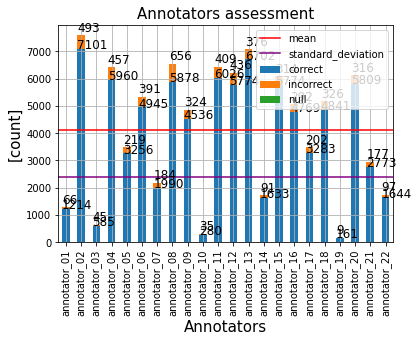

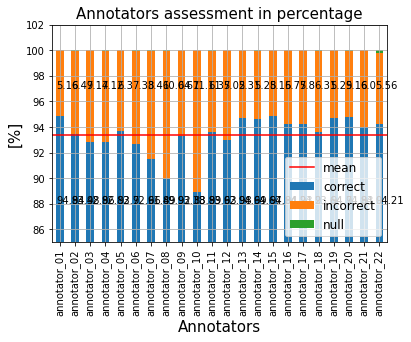

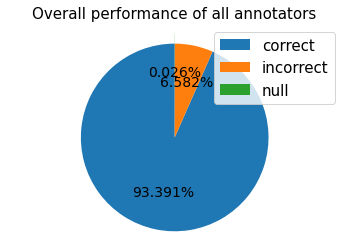

In [20]:
width = 0.8
fs = 15


# Load data
annotator_result_count_df = pd.read_csv("annotator_result_count.csv")
annotators_quality_df = pd.read_csv("annotators_quality_assessment.csv")
annotators_quality = annotators_quality_df.values.tolist()


# Amount display
labels = annotators_quality_df['vendor_user_id']
display_df = annotators_quality_df[['correct', 'incorrect', 'null']]
ax1 = display_df.plot(kind='bar', stacked=True, use_index=False)
ax1.set_xticklabels(labels)
ax1.grid(True)
ax1.set_title("Annotators assessment", fontsize=fs)
ax1.set_xlabel("Annotators", fontsize=fs)
ax1.set_ylabel("[count]", fontsize=fs)
ax1.legend(prop={'size': fs})
ax1.axhline(y=annotator_result_count_df.mean().values, color='r', linestyle='-')
ax1.axhline(y=annotator_result_count_df.std().values, color='purple', linestyle='-')
ax1.legend(['mean', 'standard_deviation', 'correct', 'incorrect', 'null'])

# - Add numbers to bars
for p, correct_count, incorrect_count in zip(ax1.patches, annotators_quality_df['correct'].values, annotators_quality_df['incorrect'].values):
    ax1.annotate(str(correct_count), (p.get_x(), p.get_height() + 10), fontsize=12)
    ax1.annotate(str(incorrect_count), (p.get_x(), p.get_height() + incorrect_count + 150), fontsize=12)


# Percentage display
ax2 = annotators_quality_df[['correct_p', 'incorrect_p', 'null_p']].plot(kind='bar', stacked=True, use_index=False)
ax2.set_ylim([85, 102])
ax2.set_xticklabels(labels)
ax2.grid(True)
ax2.set_title("Annotators assessment in percentage", fontsize=fs)
ax2.set_xlabel("Annotators", fontsize=fs)
ax2.set_ylabel("[%]", fontsize=fs)
ax2.axhline(y=annotators_quality_df['correct_p'].mean(), color='r', linestyle='-')   # draw mean line
ax2.legend(['mean', 'correct', 'incorrect', 'null'], prop={'size': 12})

# - Add numbers to bars
for p, correct_p, incorrect_p in zip(ax2.patches, annotators_quality_df['correct_p'].values, annotators_quality_df['incorrect_p'].values):
    ax2.annotate(str(round(correct_p, 2)), (p.get_x(), 88))
    ax2.annotate(str(round(incorrect_p, 2)), (p.get_x(), 97))


# Pie chart of average correct, incorrect and null samples
pie_labels = 'correct', 'incorrect', 'null'
pie_values = [annotators_quality_df['correct_p'].mean(),
              annotators_quality_df['incorrect_p'].mean(),
              annotators_quality_df['null_p'].mean()]

explode = (0, 0, 0.1)

fig3, ax3 = plt.subplots()
ax3.pie(pie_values, explode=explode, autopct='%1.3f%%', startangle=90, textprops={'fontsize': 14})
ax3.axis('equal')
ax3.set_title("Overall performance of all annotators", fontsize=fs)
ax3.legend(pie_labels, prop={'size': fs})


annotators_quality_df['correct_p'].describe()

**Annotators selection based on standard deviation**  
However, the evaluation is not fair some annotators’ sample sizes are far below the average.  
*E.g.*: annotator_01 is assessed as good while his/her total sample is only ~1200 comparing to annotator_02 with more than 7000 samples.

In order to evaluate correctly, only the annotators whose sample sizes are greater than the standard deviation value **$\sigma$** = 2403.23 are selected. 



The following annotators are excluded from the evaluation:

In [21]:
# Load data
annotator_result_count_df = pd.read_csv("annotator_result_count.csv")
annotators_quality_df = pd.read_csv("annotators_quality_assessment.csv")

# Remove annotators whose total samples are less than the standard deviation level
annotators_low_quality_df = annotators_quality_df.loc[annotators_quality_df['total'] < annotators_quality_df['total'].std()]
annotators_low_quality_df

,vendor_user_id,correct,incorrect,null,total,correct_p,incorrect_p,null_p
0,annotator_01,1214,66,0,1280,94.843750,5.156250,0.000000
2,annotator_03,585,45,0,630,92.857143,7.142857,0.000000
6,annotator_07,1990,184,1,2175,91.494253,8.459770,0.045977
9,annotator_10,280,35,0,315,88.888889,11.111111,0.000000
13,annotator_14,1633,91,1,1725,94.666667,5.275362,0.057971
18,annotator_19,161,9,0,170,94.705882,5.294118,0.000000
21,annotator_22,1644,97,4,1745,94.212034,5.558739,0.229226


With this change, the good and bad annotators are reconsidered.  

In particular, despite the high correct percentages, *annotator_01* and *annotator_14* are removed from the good annotators group as their sample sizes are too small. *Annotator_21* is taken into consideration.

The bad annotator group removed *annotator_07* and *annotator_10* with the same reason and add 3 new annotators, *annotator_04*, *annotator_06* and *annotator_12*.

count    15.000000
mean     93.529569
std       1.213275
min      89.918923
25%      93.156200
50%      93.636364
75%      94.217060
max      94.842313
Name: correct_p, dtype: float64

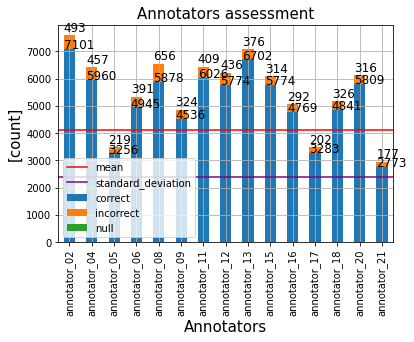

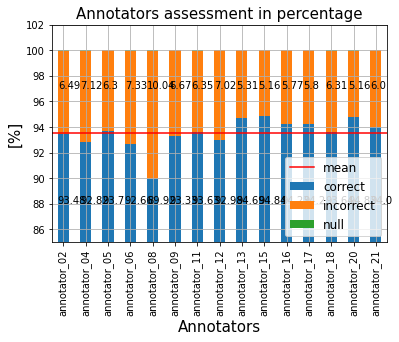

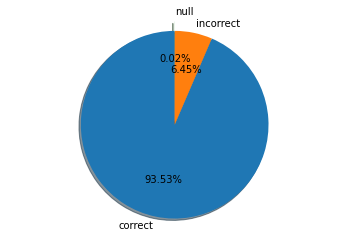

In [22]:
width = 0.8
fs = 15


# Load data
annotator_result_count_df = pd.read_csv("annotator_result_count.csv")
annotators_quality_df = pd.read_csv("annotators_quality_assessment.csv")


# Remove annotators whose total samples are less than the standard deviation level
annotators_quality_df = annotators_quality_df.loc[annotators_quality_df['total'] > annotators_quality_df['total'].std()]
annotators_quality = annotators_quality_df.values.tolist()


# Amount display
labels = annotators_quality_df['vendor_user_id']
display_df = annotators_quality_df[['correct', 'incorrect', 'null']]
ax1 = display_df.plot(kind='bar', stacked=True, use_index=False)
ax1.set_xticklabels(labels)
ax1.grid(True)
ax1.set_title("Annotators assessment", fontsize=fs)
ax1.set_xlabel("Annotators", fontsize=fs)
ax1.set_ylabel("[count]", fontsize=fs)
ax1.legend(prop={'size': fs})
ax1.axhline(y=annotator_result_count_df.mean().values, color='r', linestyle='-')
ax1.axhline(y=annotator_result_count_df.std().values, color='purple', linestyle='-')
ax1.legend(['mean', 'standard_deviation', 'correct', 'incorrect', 'null'])

# - Add numbers to bars
for p, correct_count, incorrect_count in zip(ax1.patches, annotators_quality_df['correct'].values, annotators_quality_df['incorrect'].values):
    ax1.annotate(str(correct_count), (p.get_x(), p.get_height() + 10), fontsize=12)
    ax1.annotate(str(incorrect_count), (p.get_x(), p.get_height() + incorrect_count + 150), fontsize=12)


# Percentage display
ax2 = annotators_quality_df[['correct_p', 'incorrect_p', 'null_p']].plot(kind='bar', stacked=True, use_index=False)
ax2.set_ylim([85, 102])
ax2.set_xticklabels(labels)
ax2.grid(True)
ax2.set_title("Annotators assessment in percentage", fontsize=fs)
ax2.set_xlabel("Annotators", fontsize=fs)
ax2.set_ylabel("[%]", fontsize=fs)
ax2.axhline(y=annotators_quality_df['correct_p'].mean(), color='r', linestyle='-')   # draw mean line
ax2.legend(['mean', 'correct', 'incorrect', 'null'], prop={'size': 12})

# Add numbers to bars
for p, correct_p, incorrect_p in zip(ax2.patches, annotators_quality_df['correct_p'].values, annotators_quality_df['incorrect_p'].values):
    ax2.annotate(str(round(correct_p, 2)), (p.get_x(), 88))
    ax2.annotate(str(round(incorrect_p, 2)), (p.get_x(), 97))


# Pie chart of average correct, incorrect and null samples
pie_labels = 'correct', 'incorrect', 'null'
pie_values = [annotators_quality_df['correct_p'].mean(),
              annotators_quality_df['incorrect_p'].mean(),
              annotators_quality_df['null_p'].mean()]

explode = (0, 0, 0.1)

fig3, ax3 = plt.subplots()
ax3.pie(pie_values, explode=explode, labels=pie_labels, autopct='%1.2f%%', shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

annotators_quality_df['correct_p'].describe()

**Good and bad annotators assessment**

In [23]:
width = 0.8
fs = 15


def get_duration_data(result_key, index):
    """
    Get the corresponding duration data based on result_key and index
    :param result_key: key of anonymized_project result
    :param index: index of items in result key
    :return: a list of data
    """
    vendor_user_id = ap_results[result_key]['results'][index]['user']['vendor_user_id']
    duration = ap_results[result_key]['results'][index]['task_output']['duration_ms']
    return [vendor_user_id, duration]


def check_duration_condition(result_key, index, group):
    """
    :param result_key: key of anonymized_project result
    :param index: index of items in result key
    :return: boolean value based on whether the answer data is corrupted and if user is is good annotators list
    """
    cond_1 = ap_results[result_key]['results'][index]['task_output']['corrupt_data']
    cond_2 = ap_results[result_key]['results'][index]['user']['vendor_user_id'] in group
    return not cond_1 and cond_2


# Load data
annotator_result_count_df = pd.read_csv("annotator_result_count.csv")
annotators_quality_df = pd.read_csv("annotators_quality_assessment.csv")


def get_group_data(group, file_name=None):
    """
    Function to retrieve data from a group of selected users
    """
    # Get mean durations
    # - Get durations by user
    annotator_durations = []

    for result_key in result_keys:
        result_amount = len(ap_results[result_key]['results'])

        # Collect durations which are not labeled as corrupted
        row = [get_duration_data(result_key, i) for i in range(result_amount) if check_duration_condition(result_key, i, group)]

        # - Add data to list
        annotator_durations.extend(row)

    annotator_durations_df = pd.DataFrame(data=annotator_durations, columns=['vendor_user_id', 'duration_ms'])


    # - Get mean durations
    selected_annotators_durations = []
    for item in annotator_durations_df.groupby('vendor_user_id'):
        name = item[0]
        temp_df = item[1]['duration_ms']
        temp_df = temp_df.to_frame()
        selected_annotators_durations.append([name, np.asarray(temp_df['duration_ms'], dtype=np.float).mean()])

    selected_annotators_durations_df = pd.DataFrame(selected_annotators_durations, columns=['vendor_user_id', 'mean_duration'])


    # Add sample size column
    result_count_df = annotator_result_count_df.loc[annotator_result_count_df['vendor_user_id'].isin(group)]
    result_count = result_count_df['result_count'].to_list()
    selected_annotators_durations_df['result_count'] = result_count


    # Add correct_percent column
    annotators_quality_percent_df = annotators_quality_df[['vendor_user_id', 'correct_p', 'incorrect_p', 'null_p']]

    correct_percent_df = annotators_quality_percent_df.loc[annotators_quality_percent_df['vendor_user_id'].isin(group)]
    correct_percent = correct_percent_df['correct_p'].to_list()
    selected_annotators_durations_df['correct_p'] = correct_percent

    if file_name is not None:
        selected_annotators_durations_df.to_csv(file_name, index=False)

    return selected_annotators_durations_df

From inspection, ***annotator_13*** and ***annotator_20*** are considered as **good annotators** as their sample sizes are far above the average level of 4130 samples. Their correct percentages are more than 94% (nearly 95%), higher than the average of 93.52%. Their annotation times are also below the average, which is 1289.9 ms.  

Despite the lowest average annotation time and high accuracy of 94%, the low sample size make it difficult to make a conclusion of the performance of annotator_17.

In [24]:
# Specifying good annotators group
good_annotators = ["annotator_13", "annotator_15", "annotator_16", "annotator_17", "annotator_20", "annotator_21"]

get_group_data(good_annotators)

,vendor_user_id,mean_duration,result_count,correct_p
0,annotator_13,1155.011161,7078,94.687765
1,annotator_15,1365.291721,6088,94.842313
2,annotator_16,1269.793124,5061,94.230389
3,annotator_17,991.886370,3485,94.203730
4,annotator_20,1173.149200,6126,94.825335
5,annotator_21,1238.922373,2950,94.000000


All four annotators have high sample size with the accuracy below the average of 93.52%. However, beside *annotator_08*, the others three have the accuracy of 92%, which is close to the average line.

Only *annotator_08* has the lowest accuracy percentage of 89.9% and high average annotation time of 1434 ms. This cause *annotator_08* to be considered as low performance annotator.

In [25]:
# Specifying bad annotators group
bad_annotators = ["annotator_04", "annotator_06", "annotator_08", "annotator_12"]
get_group_data(bad_annotators)

,vendor_user_id,mean_duration,result_count,correct_p
0,annotator_04,1113.926958,6421,92.820433
1,annotator_06,1496.940217,5337,92.655050
2,annotator_08,1434.702111,6537,89.918923
3,annotator_12,1306.305475,6210,92.979066
